# 2 - Data Extraction - Natality Data

In this notebook we'll extract how many brazilians were born and registered 2015-present, by month and state. 

This dataset isn't available via API, so we'll need to scrape the Civil Registry Data Transparency Portal information webpage on birth registrations (https://transparencia.registrocivil.org.br/registros)

In [1]:
import datetime as dt
import pandas as pd
from matplotlib import rcParams, rcParamsDefault, pyplot as plt
import seaborn as sns

rcParams.update(rcParamsDefault)
rcParams['figure.figsize'] = (14, 10)
rcParams['figure.dpi'] = 100

sns.set_theme()

Scraper is implemented in `playwright`. Due to issues with Jupyter and `asyncio`, it's implemented in `extract_civilregistry.py`, which must be executed separately.

This script exports a `.parquet` dataframe to the `data/processed` folder, which can be opened with `pandas`

In [2]:
filename = r'../data/processed/brazil_natality_state_monthly.parquet'

df = pd.read_parquet(filename)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2619 entries, 0 to 26
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   month              2619 non-null   datetime64[ns]
 1   state              2619 non-null   category      
 2   registered_births  2619 non-null   int32         
dtypes: category(1), datetime64[ns](1), int32(1)
memory usage: 55.0 KB


In [3]:
df.head(10)

,month,state,registered_births
0,2023-01-01,Acre,840
1,2023-01-01,Alagoas,2378
2,2023-01-01,Amapá,1070
3,2023-01-01,Amazonas,4226
4,2023-01-01,Bahia,9097
5,2023-01-01,Ceará,6725
6,2023-01-01,Distrito Federal,2557
7,2023-01-01,Espírito Santo,3046
8,2023-01-01,Goiás,4769
9,2023-01-01,Maranhão,5734


In [4]:
df[df.month == '2023-02']

,month,state,registered_births


In [5]:
df['year'] = df['month'].dt.year

In [6]:
df['month_name'] = df['month'].dt.strftime("%b")
months_cat = pd.CategoricalDtype(
    categories = ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'),
    ordered = True
)

df['month_name'] = df['month_name'].astype(months_cat)

In [7]:
# sort ascending by date
df = df.sort_values(by = ['month', 'state'])

In [8]:
# .reset_index() didn't take during extraction. Let's try again
df = df.reset_index(drop = True)

In [9]:
# let's apply the transformation proposed in https://boriquagato.substack.com/p/swedish-birthrate-data-november-update
# variation in each month compared to the same month in the previous year (e.g. % change from jan-2022 compared to jan-2021)

df['registered_births_dif_12m'] = df.groupby(['state','month_name'])['registered_births'].pct_change()
df_covid = df[df['month']>'2020'].copy()
df_covid[(df_covid['state'].str.contains('Janeiro'))&(df_covid['month_name']=='Feb')]

,month,state,registered_births,year,month_name,registered_births_dif_12m
1667,2020-02-01,Rio de Janeiro,15726,2020,Feb,-0.093132
1991,2021-02-01,Rio de Janeiro,15310,2021,Feb,-0.026453
2315,2022-02-01,Rio de Janeiro,15175,2022,Feb,-0.008818


In [10]:
df_covid

,month,state,registered_births,year,month_name,registered_births_dif_12m
1647,2020-02-01,Acre,1118,2020,Feb,-0.166915
1648,2020-02-01,Alagoas,3311,2020,Feb,-0.183880
1649,2020-02-01,Amapá,1186,2020,Feb,-0.034988
1650,2020-02-01,Amazonas,4749,2020,Feb,-0.069553
1651,2020-02-01,Bahia,13117,2020,Feb,-0.147250
...,...,...,...,...,...,...
2614,2023-01-01,Roraima,612,2023,Jan,-0.449145
2615,2023-01-01,Santa Catarina,6164,2023,Jan,-0.276526
2616,2023-01-01,Sergipe,1821,2023,Jan,-0.333699
2617,2023-01-01,São Paulo,31292,2023,Jan,-0.298071


<AxesSubplot: xlabel='month_name', ylabel='registered_births_dif_12m'>

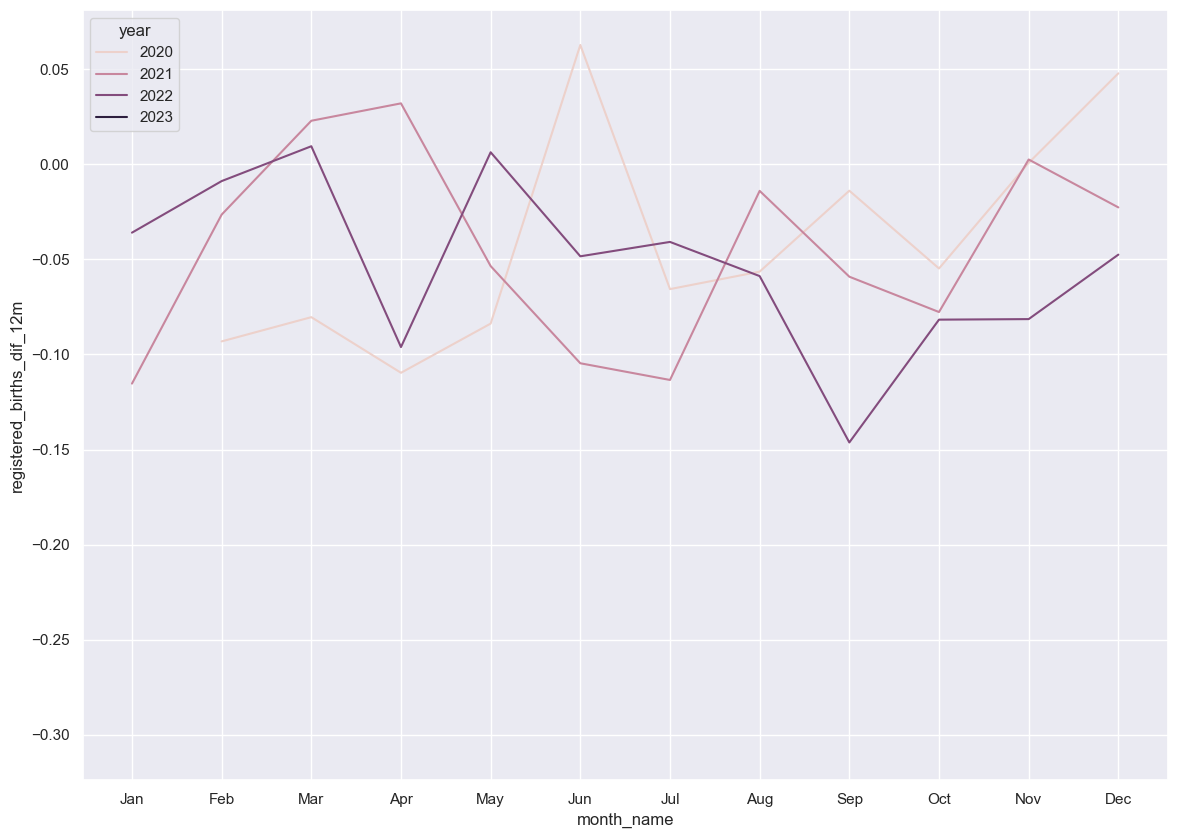

In [11]:
sns.lineplot(
    data = df_covid[df_covid['state'].str.contains('Janeiro')],
    x = 'month_name', y = 'registered_births_dif_12m', hue = 'year', 
    errorbar = ('ci', False),
)

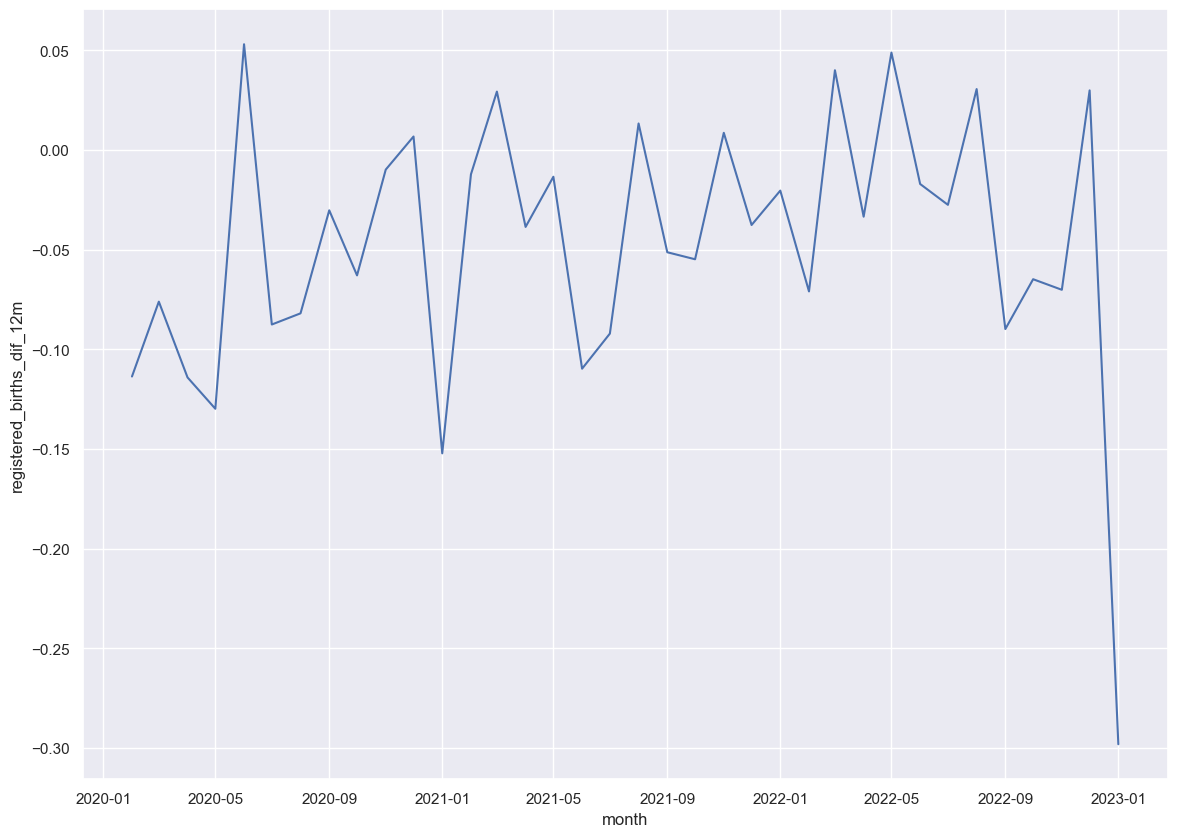

In [12]:
sns.lineplot(
    data = df_covid[df_covid['state'].str.contains('Paulo')],
    x = 'month', y = 'registered_births_dif_12m',
)
plt.show()

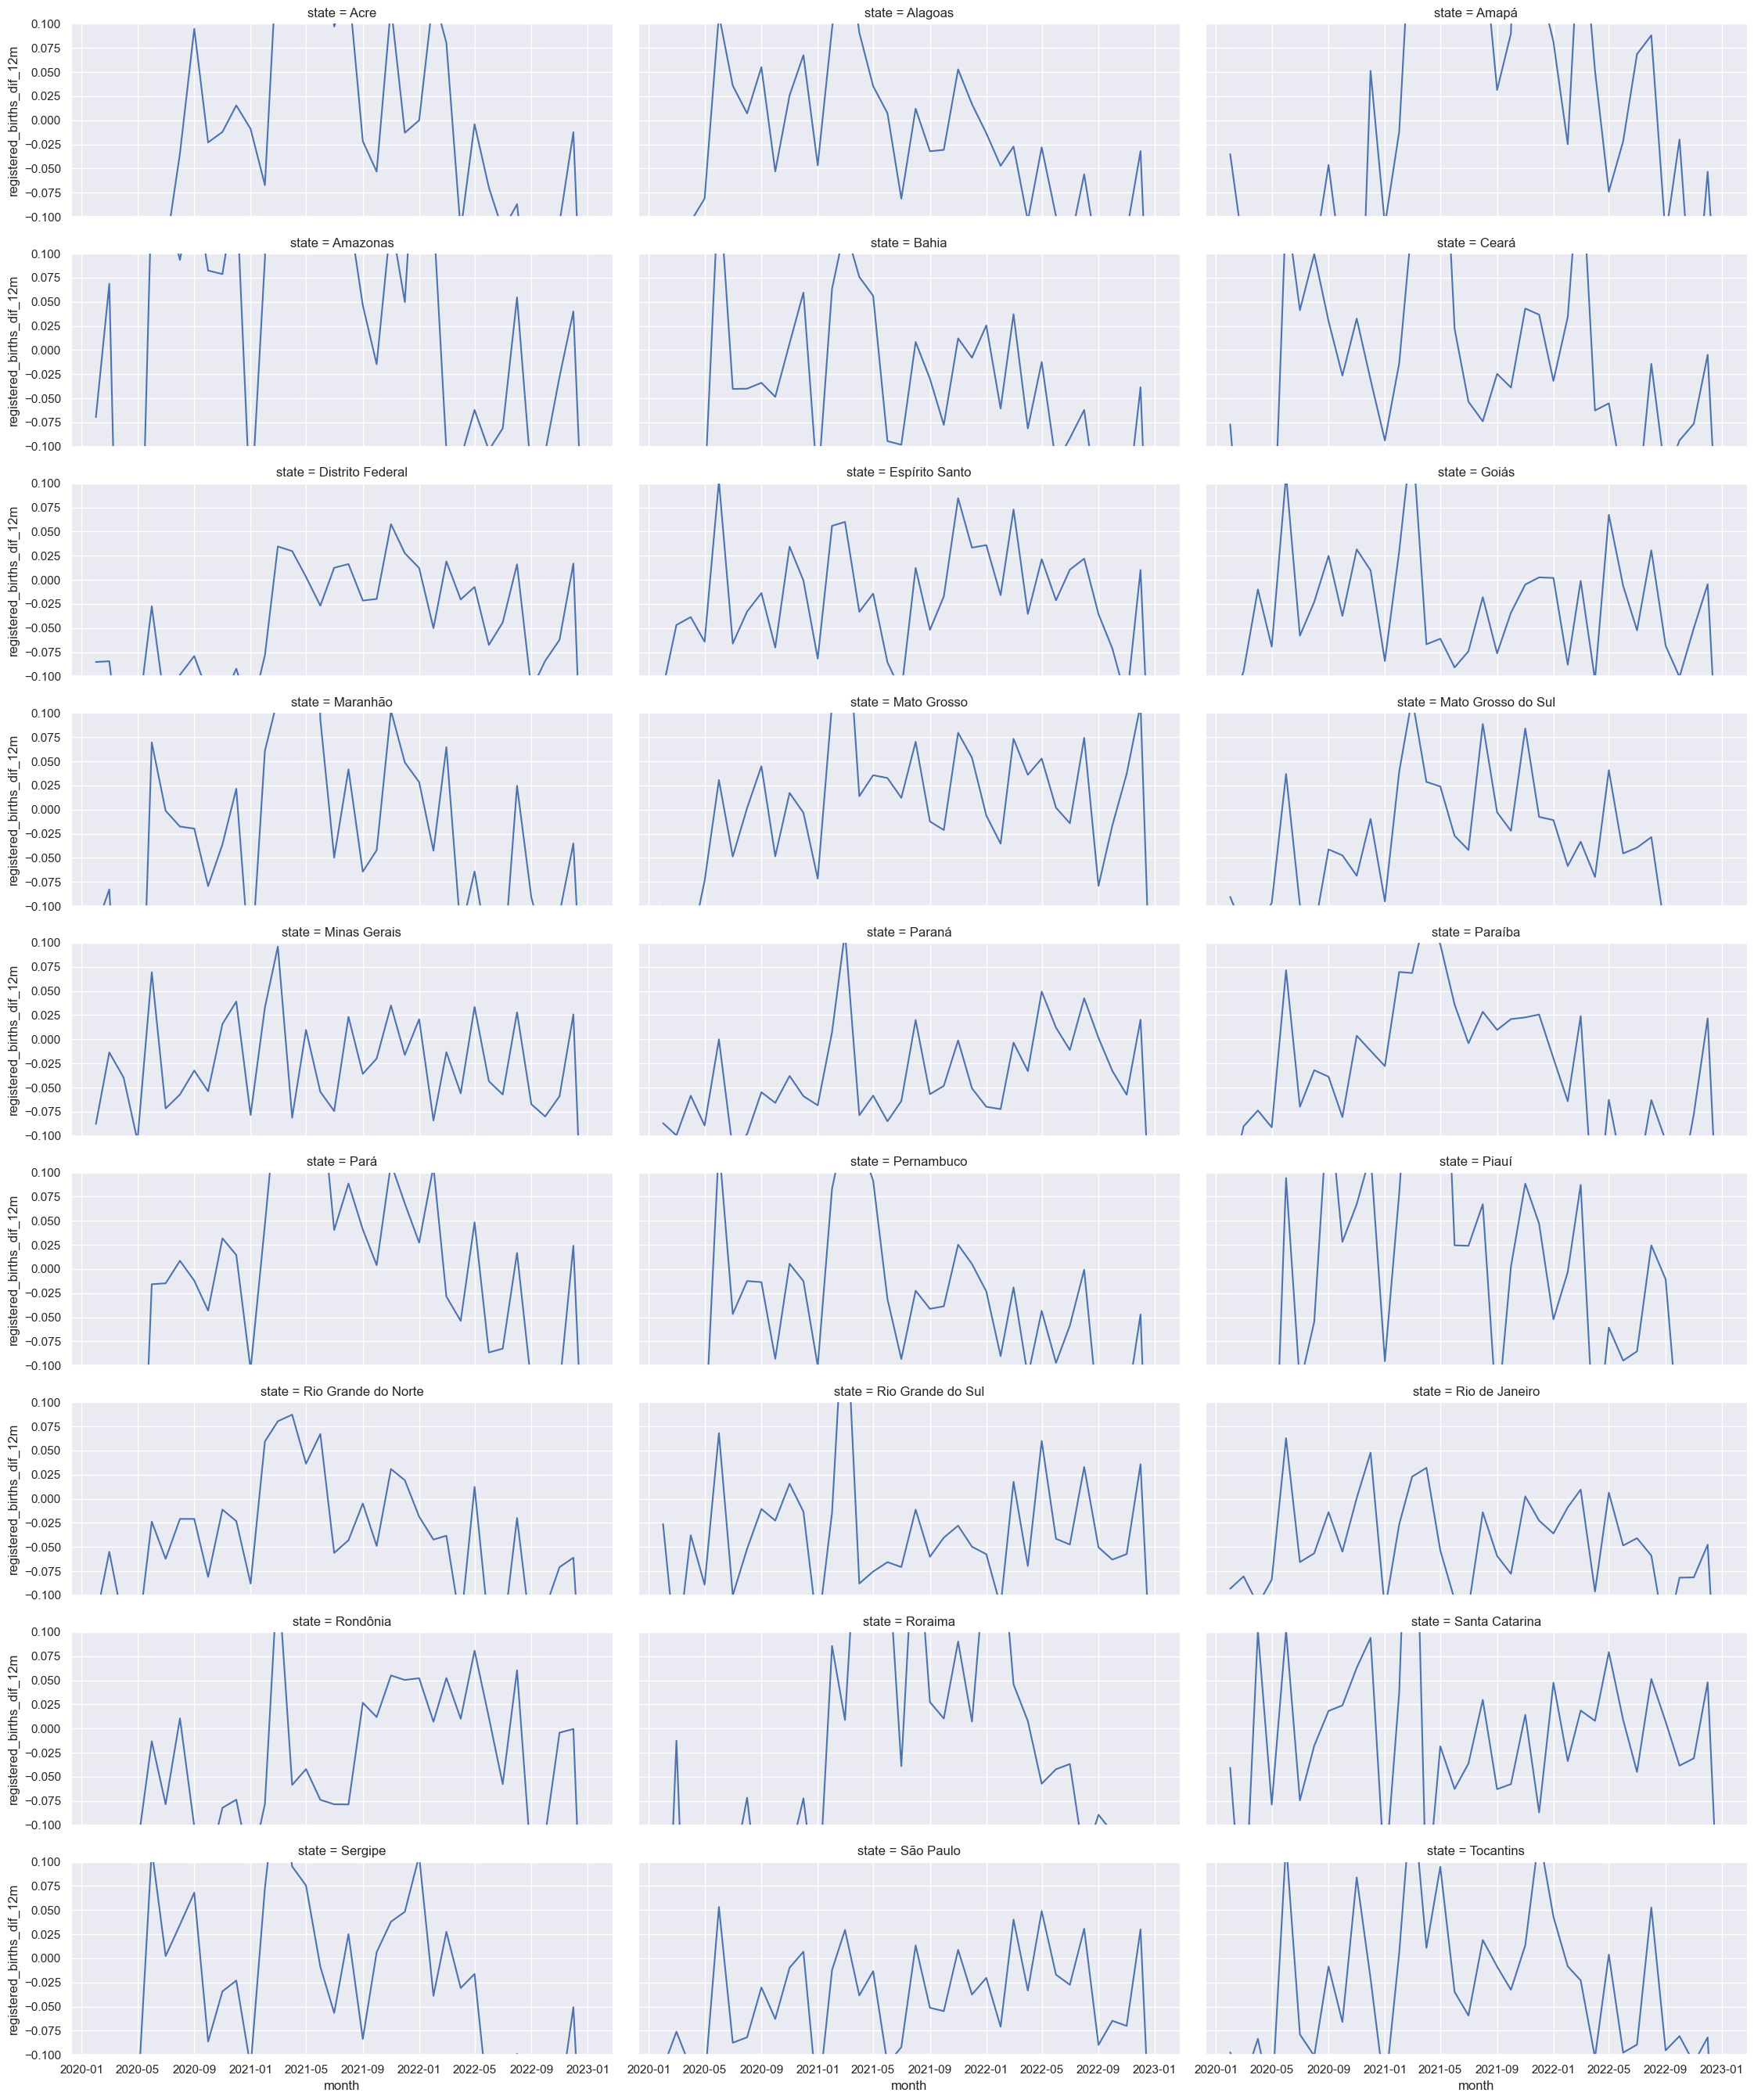

In [20]:
facetgrid = sns.FacetGrid(data = df_covid, col = 'state', col_wrap = 3, aspect = 2.5, ylim = [-.1, .1])
facetgrid.map(sns.lineplot, 'month', 'registered_births_dif_12m')